<a href="https://colab.research.google.com/github/GPN87/Image-detection/blob/main/classifier_partdeux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import imghdr

In [230]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
data_dir = '/content/drive/MyDrive/data/'


In [232]:
os.listdir(data_dir)

['crimson', 'eastern']

In [233]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [234]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Start of loading data

In [235]:
import numpy as np

In [236]:
# keras utils is a data pipeline 'helper'. It builds the image dataset on the fly.
# batches them, classifies them. makes sure they are consistent size.
data = tf.keras.utils.image_dataset_from_directory(data_dir)



Found 448 files belonging to 2 classes.


In [237]:
#converts into a numpy iterator
#so we can actually access it
data_iterator = data.as_numpy_iterator()

In [238]:
batch = data_iterator.next()

#each image in the batch consists of an array representing the image, and a '1' or '0' representing the classification

batch[0].shape
#It's really important to get the shape of your images, so you refer to them correctly in the model below.
#in this case, 32 images, with 256 height, 256 width, 3 channels (i.e. color)


(32, 256, 256, 3)

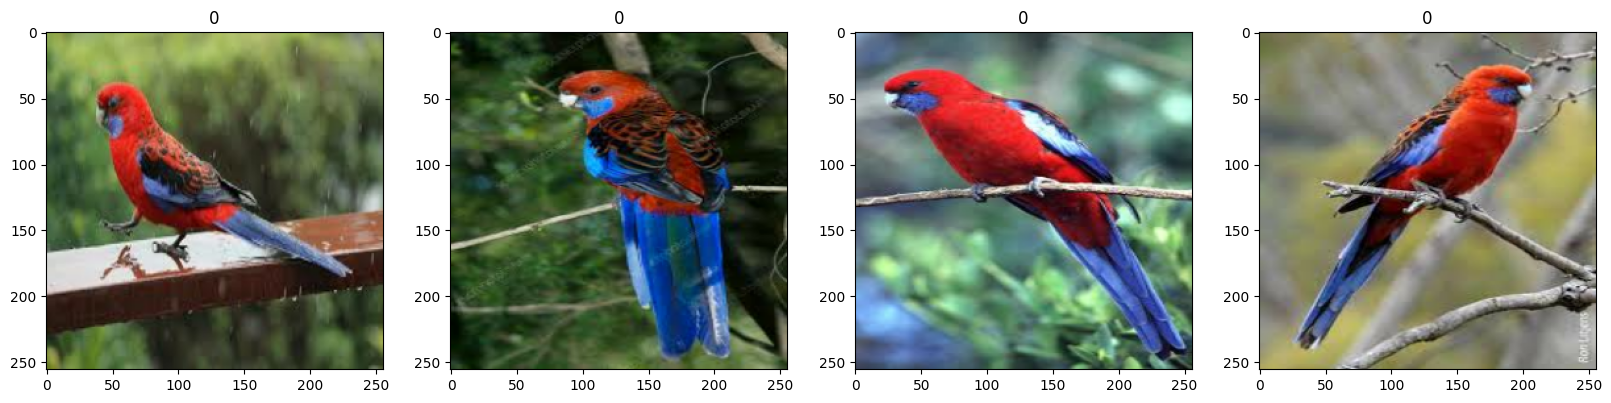

In [239]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
#0s are crimsons and 1s are easterns

In [240]:
data = data.map(lambda x,y: (x/255, y))

In [241]:
data.as_numpy_iterator().next()

(array([[[[0.24705882, 0.1882353 , 0.20784314],
          [0.25245097, 0.19362745, 0.21256128],
          [0.2769608 , 0.21813725, 0.23400736],
          ...,
          [0.484038  , 0.41344976, 0.33091298],
          [0.4794424 , 0.40885416, 0.3232537 ],
          [0.47843137, 0.40784314, 0.32156864]],
 
         [[0.25346202, 0.19463848, 0.21424632],
          [0.258217  , 0.19939348, 0.2183273 ],
          [0.27983063, 0.22100711, 0.2368772 ],
          ...,
          [0.49281603, 0.4222278 , 0.33969104],
          [0.48848376, 0.4178955 , 0.33229503],
          [0.48753065, 0.4169424 , 0.33066788]],
 
         [[0.2825674 , 0.22374387, 0.24335171],
          [0.2844262 , 0.22560269, 0.24453652],
          [0.2928754 , 0.23405187, 0.24992198],
          ...,
          [0.5327163 , 0.46212804, 0.3795913 ],
          [0.5295808 , 0.4589925 , 0.37339202],
          [0.5288909 , 0.4583027 , 0.37202817]],
 
         ...,
 
         [[0.5335172 , 0.37273285, 0.28645834],
          [0.53284

Pre-processing the data

In [242]:
#you've got to scale the image values to be between '0' and '1' instead of 0 to 255.
#you use a lambda function to do that
#The data pipeline has a 'map' function that allows us to lambda. So it makes the calculation automatically.
#'x' represents the image array. so we're dividing it by 255 to standardise the number. Nothing happens to 'y'


In [243]:
scaled_iterator = data.as_numpy_iterator()

In [244]:
batch = scaled_iterator.next()

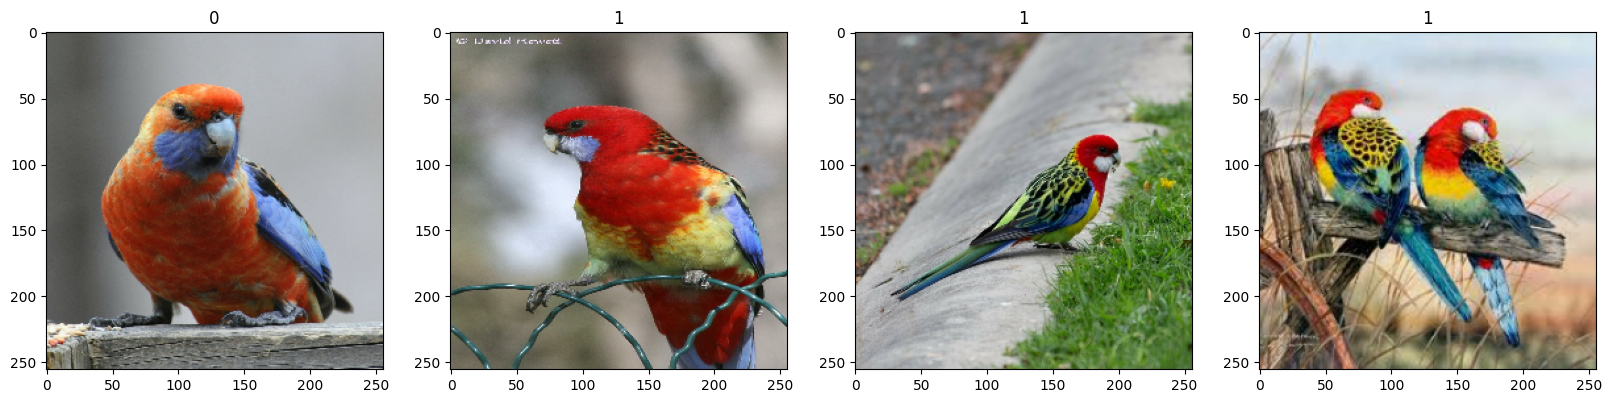

In [245]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data.

In [246]:
len(data)

14

In [247]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [248]:
train_size

9

In [249]:
#Training data: what is used to train the model
#validation data: what we use to evaluate model while we're 
#Test data: used post training. 
# uses the 'Take' and 'skip' methods

In [250]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [251]:
num_classes = 2

Build Deep Learning Model

In [252]:
#Uses the Keras sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

#There are two model building APIs in tensorflow. The first is "sequential". Good when you've got one data input and one data output. Quick, easy.
#another is functional API. when you've got multiple connections.
#Conv2D, MaxPooling, Dense, Flatten, Dropout are all layers. See your background on CNN.

In [266]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

#16 is the number of filters. Each filter matrix is 3x3 pixels. Each filter moves 1 pixel at a time. Input shape corresponds to the image array mentioned above.
#generally start with a relu activation function, if you dont want negative values. and output a sigmoid if '0' and '1'
#Dense layer = fully connected layer in Keras parlance.


In [267]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#the metric we want to track is "accuracy"

In [268]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

Train the data

In [269]:
#create a log directory.
logdir = '/content/drive/MyDrive/logs/'

In [270]:
#this creates a callback. Good for creating callbacks.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [271]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
9/9 [==============================] - 34s 3s/step - loss: 0.7998 - accuracy: 0.5312 - val_loss: 0.6328 - val_accuracy: 0.6250
Epoch 2/20
9/9 [==============================] - 28s 3s/step - loss: 0.6133 - accuracy: 0.6181 - val_loss: 0.5770 - val_accuracy: 0.6667
Epoch 3/20
9/9 [==============================] - 32s 3s/step - loss: 0.5242 - accuracy: 0.7917 - val_loss: 0.4258 - val_accuracy: 0.8542
Epoch 4/20
9/9 [==============================] - 32s 3s/step - loss: 0.3890 - accuracy: 0.8333 - val_loss: 0.3034 - val_accuracy: 0.8750
Epoch 5/20
9/9 [==============================] - 32s 3s/step - loss: 0.3083 - accuracy: 0.8542 - val_loss: 0.2147 - val_accuracy: 0.9271
Epoch 6/20
9/9 [==============================] - 32s 3s/step - loss: 0.2980 - accuracy: 0.8854 - val_loss: 0.1761 - val_accuracy: 0.9583
Epoch 7/20
9/9 [==============================] - 32s 3s/step - loss: 0.2393 - accuracy: 0.9340 - val_loss: 0.2160 - val_accuracy: 0.9271
Epoch 8/20
9/9 [==================

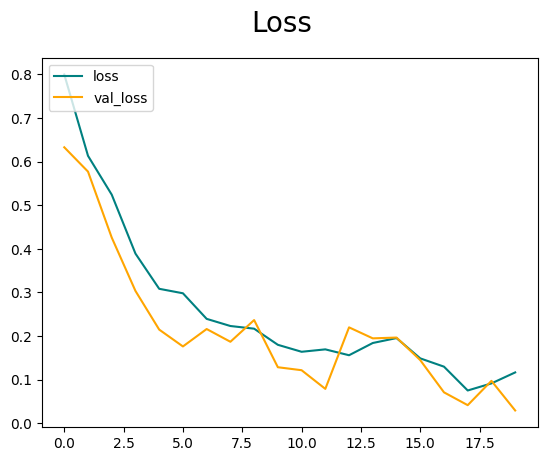

In [272]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

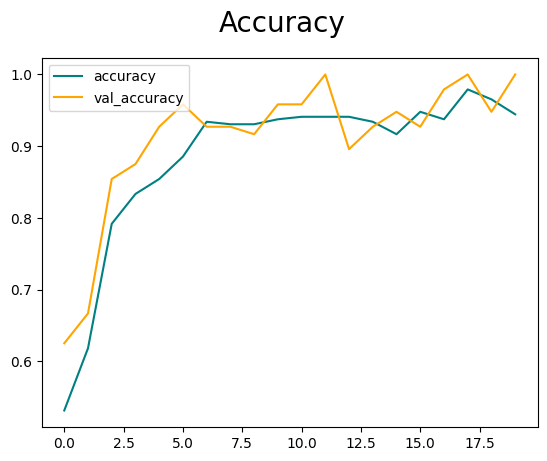

In [273]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [274]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [275]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [276]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_labels = (yhat > 0.5).astype(int)  # Convert probabilities to binary labels
    pre.update_state(y, yhat_labels)
    re.update_state(y, yhat_labels)
    acc.update_state(y, yhat_labels)

1/1 [==============================] - 1s 565ms/step


In [277]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9642857313156128, Recall: 1.0, Accuracy: 0.984375


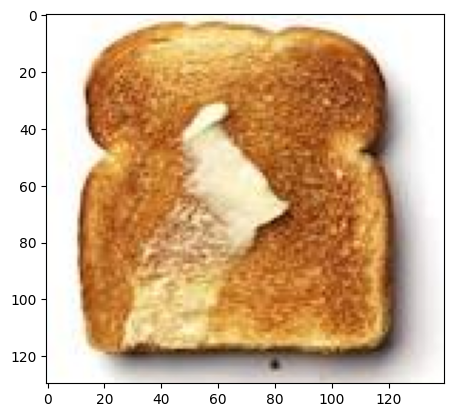

In [330]:
filename = '/content/drive/MyDrive/nontest2.jpeg'
if os.path.exists(filename):
    img1 = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Error: Image file does not exist.")

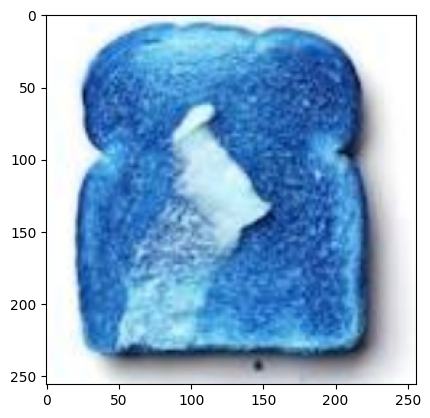

In [331]:
resize = tf.image.resize(img1, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
#It's only a weird colour because we've opened it up in cv2.

In [335]:
# yhat_crimson = model.predict(np.expand_dims(resize / 255, 0))[0][0]
# yhat_eastern = model.predict(np.expand_dims(resize / 255, 0))[0][1]
#The Neural network expects a batch of images, not a single image.
#So we need to encapsulate it in another dimension.

prediction = model.predict(np.expand_dims(resize / 255, 0))[0]

class_labels = ['Crimson Rosella', 'Eastern Rosella']
threshold_crimson = 0.85  # Threshold for classifying as Crimson Rosella
threshold_eastern = 0.85  # Threshold for classifying as Eastern Rosella

1/1 [==============================] - 0s 76ms/step


In [336]:
# class_index = np.argmax(prediction)
# class_prob = prediction[class_index]
# predicted_class_index = np.argmax(prediction)

In [338]:
# Check if the predicted class is Crimson Rosella
if prediction > threshold_crimson:
    print(f'Beep boop.. this is a {class_labels[0]}')
# Check if the predicted class is Eastern Rosella
elif prediction < 1 - threshold_eastern:
    print(f'Beep boop.. this is an {class_labels[1]}')
# The predicted class is neither Crimson Rosella nor Eastern Rosella
else:
    print('Beep boop.. this is neither a Crimson Rosella nor an Eastern Rosella')

Beep boop.. this is neither a Crimson Rosella nor an Eastern Rosella
